In [1]:
import numpy as np
import xarray as xr
import os, tqdm

import matplotlib.pyplot as plt 
plt.style.use("/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/setup/matplotlib_style/standard_plot_style.mplstyle")
# plt.rcParams["font.size"] = 10
# plt.rcParams["axes.titlesize"] = "medium"

path = '/mnt/c/Data/Master Thesis/1000_sample_50_mikrosecond_demodulated.nc'
data = xr.open_dataset(path)



In [35]:
data

<xarray.Dataset>
Dimensions:        (adc_timestamp: 5000, sample: 1000)
Coordinates:
  * adc_timestamp  (adc_timestamp) float64 4.5e-09 1.45e-08 ... 4.999e-05
  * sample         (sample) int32 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    I_ground       (sample, adc_timestamp) float32 -0.004263 ... 0.01437
    Q_ground       (sample, adc_timestamp) float32 0.001344 ... 0.001567
    I_excited      (sample, adc_timestamp) float32 0.002125 ... -0.003625
    Q_excited      (sample, adc_timestamp) float32 0.0003347 ... 0.01401

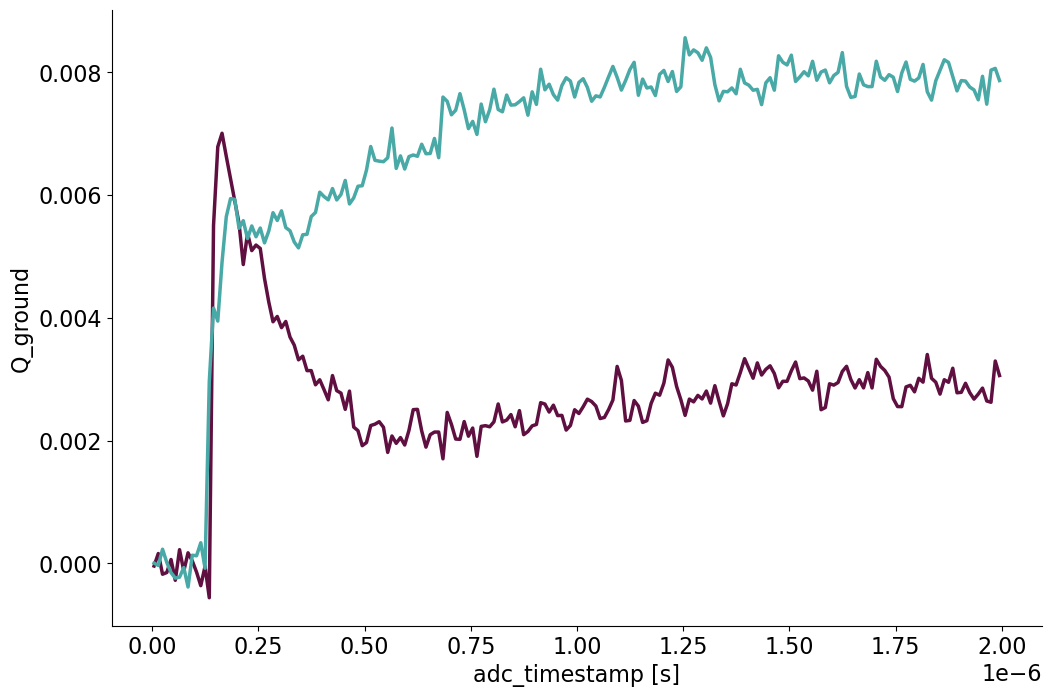

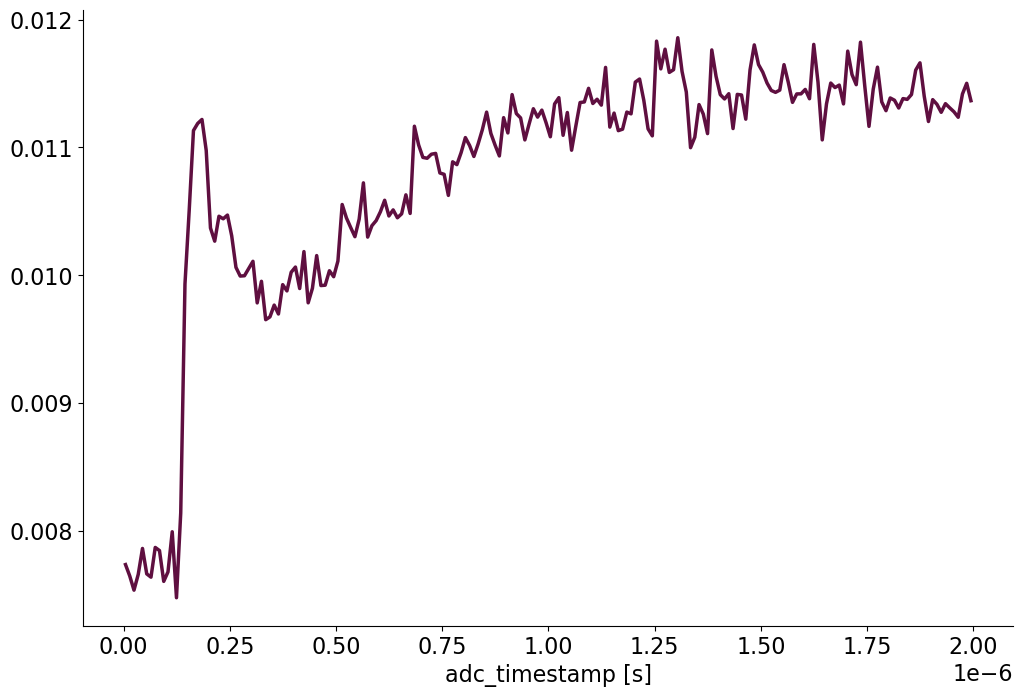

In [39]:
data.I_ground.sel(adc_timestamp = slice(0, 2000e-9)).mean("sample").plot()
data.Q_ground.sel(adc_timestamp = slice(0, 2000e-9)).mean("sample").plot()

plt.figure()
radius = np.sqrt(data.I_ground.sel(adc_timestamp = slice(0, 2000e-9)) ** 2 + data.Q_ground.sel(adc_timestamp = slice(0, 2000e-9)) ** 2)
radius.mean("sample").plot()

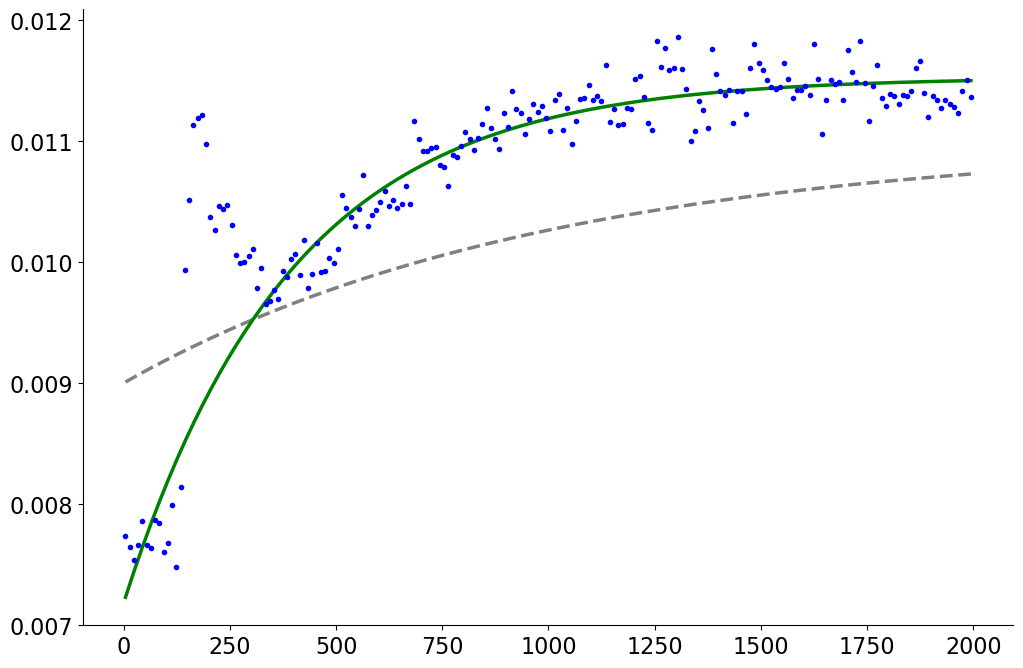

In [78]:
from scipy.optimize import curve_fit

func = lambda x, a, b, c: a * np.exp(-x / b) + c

fitting_data = radius.mean("sample").sel(adc_timestamp=slice(0e-9, 2000e-9))

p0 = [-0.002, 1000, 0.011]

popt, pcov = curve_fit(
    func,
    fitting_data.sel(adc_timestamp=slice(300e-9, 2000e-9)).adc_timestamp * 1e9,
    fitting_data.sel(adc_timestamp=slice(300e-9, 2000e-9)).values,
    p0=[-0.2, 100, 0.012],
)
plt.plot(
    fitting_data.adc_timestamp * 1e9,
    func(fitting_data.adc_timestamp * 1e9, *p0),
    color="gray",
    ls="--",
    label="guess",
)
plt.plot(
    fitting_data.adc_timestamp * 1e9,
    func(fitting_data.adc_timestamp * 1e9, *popt),
    "g-",
    label="fit",
)
plt.plot(fitting_data.adc_timestamp * 1e9, fitting_data.values, "b.", label="data")

In [79]:
popt, np.sqrt(np.diag(pcov))

(array([-4.34623282e-03,  3.92779644e+02,  1.15266220e-02]),
 array([3.01941425e-04, 2.77716973e+01, 3.26288393e-05]))

kappa = 1 / 400 ns ?

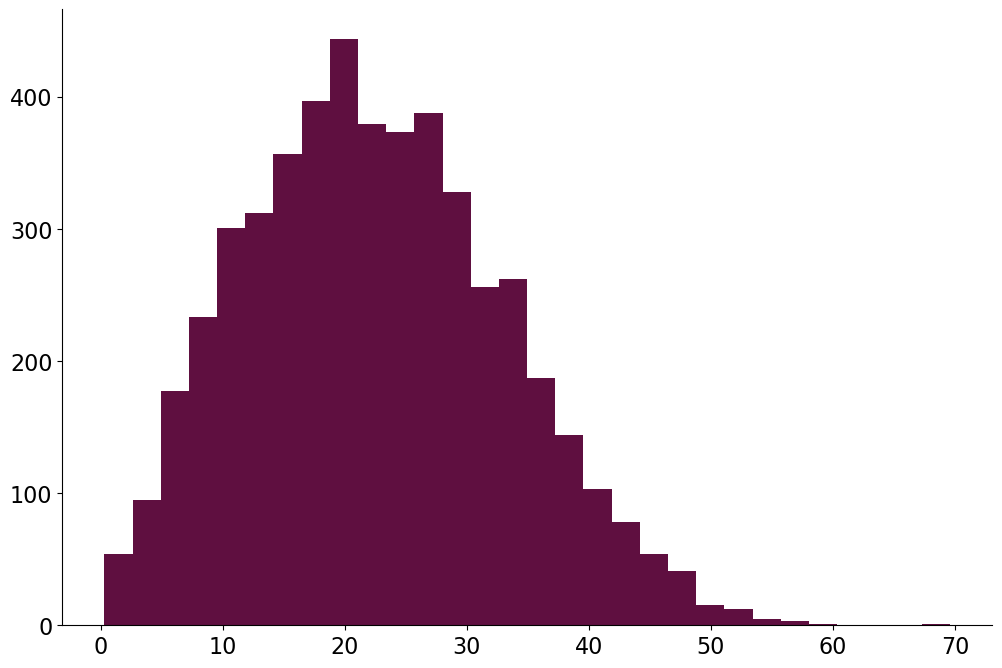

In [2]:
radius = np.sqrt(data.I_excited**2 + data.Q_excited**2).sel(sample = 1)
plt.hist(radius / 0.5e-3, bins = 30)

exchange_rate = 1.0 / 0.5e-3 # How any photons for your voltage

With a Naive guess this would be around 25 photons such that we have 1 photon $\approx$ 0.5 mV.

(array([  4.,   1.,   2.,  22.,  47.,  94., 105., 121.,  96.,  51.,  47.,
         32.,  23.,  30.,  16.,  24.,  30.,  33.,  33.,  18.,  23.,  27.,
         28.,  22.,  28.,  19.,  10.,   8.,   3.,   3.]),
 array([0.00628877, 0.00633006, 0.00637134, 0.00641263, 0.00645391,
        0.0064952 , 0.00653648, 0.00657777, 0.00661905, 0.00666034,
        0.00670162, 0.00674291, 0.00678419, 0.00682548, 0.00686676,
        0.00690805, 0.00694933, 0.00699062, 0.0070319 , 0.00707319,
        0.00711447, 0.00715576, 0.00719705, 0.00723833, 0.00727962,
        0.0073209 , 0.00736219, 0.00740347, 0.00744476, 0.00748604,
        0.00752733], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7fc870e37a60>])

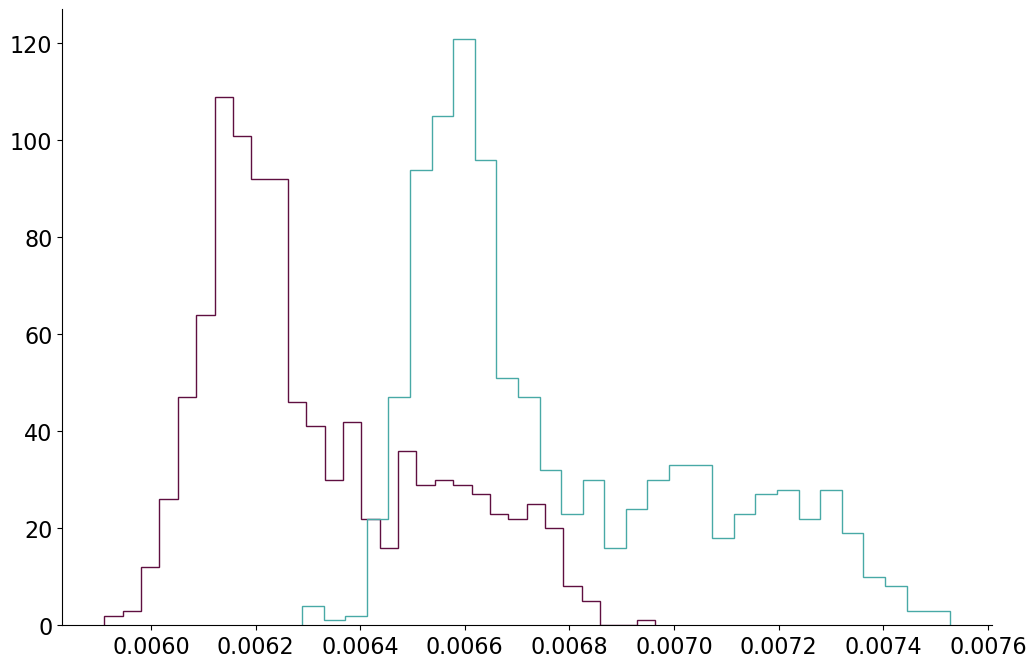

In [18]:
plt.hist(data.I_ground.sel(adc_timestamp = slice(0, 1000)).std(dim = 'adc_timestamp'), bins = 30, histtype = "step")
plt.hist(data.Q_ground.sel(adc_timestamp = slice(0, 1000)).std(dim = 'adc_timestamp'), bins = 30, histtype = "step")

(array([13., 10., 11., 17., 18., 17., 23., 37., 46., 68., 88., 91., 69.,
        74., 40., 29., 15.,  5.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([0.008     , 0.00806897, 0.00813793, 0.0082069 , 0.00827586,
        0.00834483, 0.00841379, 0.00848276, 0.00855172, 0.00862069,
        0.00868966, 0.00875862, 0.00882759, 0.00889655, 0.00896552,
        0.00903448, 0.00910345, 0.00917241, 0.00924138, 0.00931034,
        0.00937931, 0.00944828, 0.00951724, 0.00958621, 0.00965517,
        0.00972414, 0.0097931 , 0.00986207, 0.00993103, 0.01      ]),
 <BarContainer object of 29 artists>)

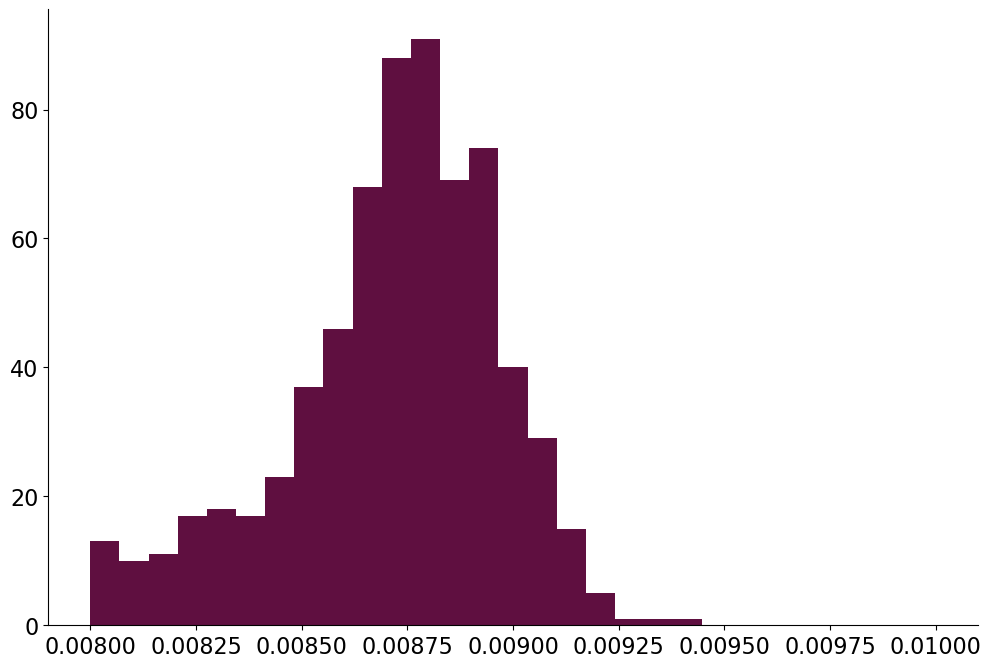

In [30]:
plt.hist(data.Q_ground.sel(adc_timestamp = slice(0, 10000)).mean("adc_timestamp"), bins = np.linspace(0.008, 0.010, 30))

In [31]:
0.0085 * exchange_rate

17.0

In [20]:
0.066 * np.sqrt(10 * 8 * 2) 

0.8348413022844522

(array([  1.,   1.,   1.,   1.,   4.,   9.,  16.,  27.,  45.,  74., 111.,
        178., 232., 349., 392., 446., 486., 494., 473., 426., 407., 311.,
        206., 140.,  93.,  33.,  23.,  14.,   5.,   2.]),
 array([-4.08267021e+01, -3.74283218e+01, -3.40299416e+01, -3.06315594e+01,
        -2.72331772e+01, -2.38347969e+01, -2.04364166e+01, -1.70380344e+01,
        -1.36396542e+01, -1.02412729e+01, -6.84289169e+00, -3.44451070e+00,
        -4.61296067e-02,  3.35225153e+00,  6.75063229e+00,  1.01490135e+01,
         1.35473948e+01,  1.69457760e+01,  2.03441563e+01,  2.37425385e+01,
         2.71409187e+01,  3.05392990e+01,  3.39376793e+01,  3.73360634e+01,
         4.07344437e+01,  4.41328239e+01,  4.75312042e+01,  5.09295845e+01,
         5.43279686e+01,  5.77263489e+01,  6.11247292e+01], dtype=float32),
 <BarContainer object of 30 artists>)

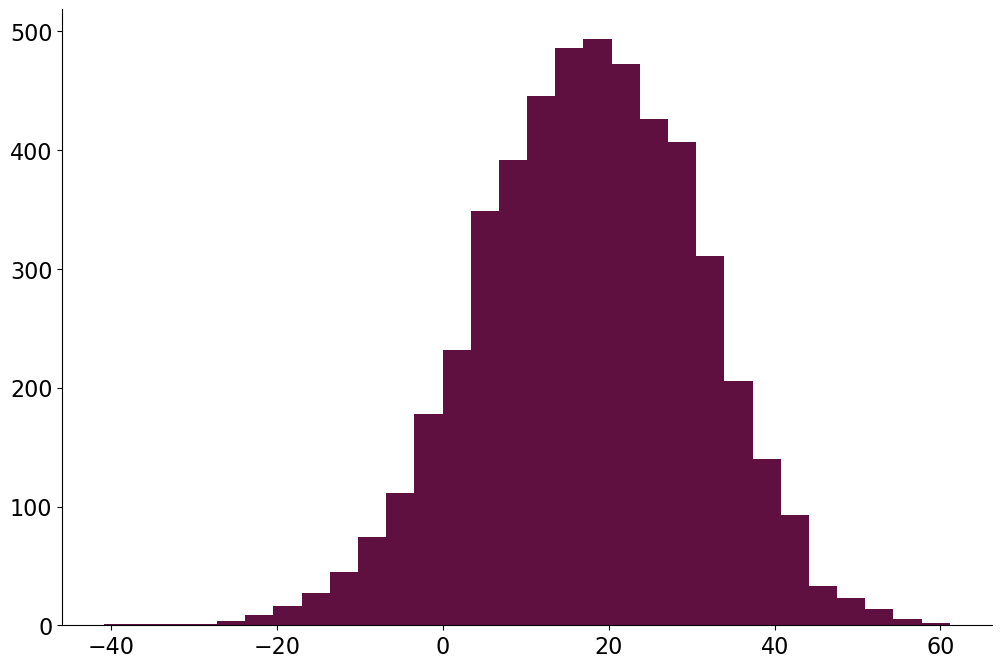

In [7]:
single_path_I = (data.I_ground * exchange_rate).sel(sample = 1)
plt.hist(single_path_I, bins = 30)

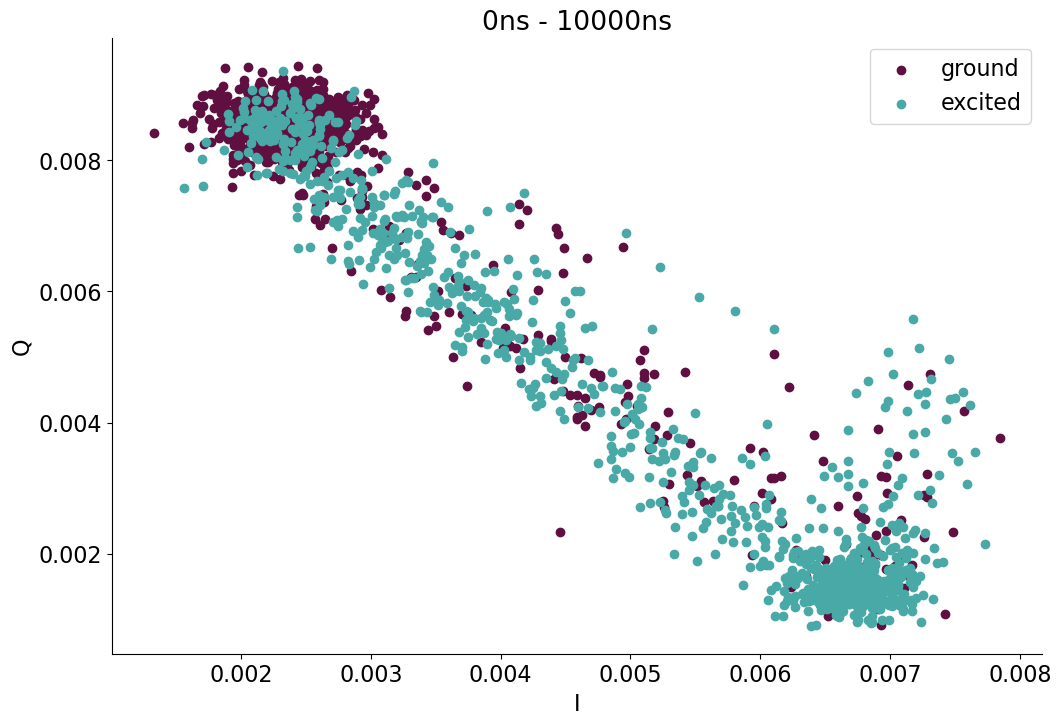

In [16]:
fig, ax = plt.subplots()
mean_and_scatter_plot(data, 0, 10000, ax)